In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="urllib3")
# Setting the working directory
import os
os.chdir('/Users/vishalraj/GitHub/Flight_Fare_Prediction')

In [2]:
from src.data.make_dataset import load_and_save_data_by_folder

path = 'data/raw'

# Load and save concatenated data by folder
load_and_save_data_by_folder(path)

In [3]:
import pandas as pd
df = pd.read_csv("data/interim/ATL/ATL_concatenated.csv")
print(df.head())

                              legId  searchDate  flightDate startingAirport  \
0  ee4aaff43c557e1704ebf52b8abf25ad  2022-05-13  2022-06-15             ATL   
1  284bffb121ffdafba55f69d6d89a4b7d  2022-05-13  2022-06-15             ATL   
2  8efdd07b82644146d45978f61d081f3b  2022-05-13  2022-06-15             ATL   
3  e03c8964b4feb4e206636a9c5c0015b2  2022-05-13  2022-06-15             ATL   
4  f44658d6761962cecc3eabc0a29d6ef9  2022-05-13  2022-06-15             ATL   

  destinationAirport travelDuration  isBasicEconomy  isRefundable  isNonStop  \
0                BOS        PT8H51M           False         False      False   
1                BOS       PT12H31M           False         False      False   
2                BOS        PT4H35M           False         False      False   
3                BOS        PT4H38M           False         False      False   
4                BOS        PT6H43M           False         False      False   

   totalFare  ...  segmentsArrivalTimeEpochS

In [3]:
# Extract dtypes
dtype_dict = df.dtypes.to_dict()

print(dtype_dict)

{'legId': dtype('O'), 'searchDate': dtype('O'), 'flightDate': dtype('O'), 'startingAirport': dtype('O'), 'destinationAirport': dtype('O'), 'travelDuration': dtype('O'), 'isBasicEconomy': dtype('bool'), 'isRefundable': dtype('bool'), 'isNonStop': dtype('bool'), 'totalFare': dtype('float64'), 'totalTravelDistance': dtype('float64'), 'segmentsDepartureTimeEpochSeconds': dtype('O'), 'segmentsDepartureTimeRaw': dtype('O'), 'segmentsArrivalTimeEpochSeconds': dtype('O'), 'segmentsArrivalTimeRaw': dtype('O'), 'segmentsArrivalAirportCode': dtype('O'), 'segmentsDepartureAirportCode': dtype('O'), 'segmentsAirlineName': dtype('O'), 'segmentsAirlineCode': dtype('O'), 'segmentsEquipmentDescription': dtype('O'), 'segmentsDurationInSeconds': dtype('O'), 'segmentsDistance': dtype('O'), 'segmentsCabinCode': dtype('O')}


In [2]:
from src.data.data_preprocessor import DataPreprocessor

# Create an instance of the DataPreprocessor class
preprocessor = DataPreprocessor()

# Process all folders
preprocessor.merge_and_preprocess_all_datasets()

print("Checking unique values for 'startingAirport' after preprocessing:")
print(preprocessor.data['startingAirport'].unique())

print("\nCategory Mappings:")
print(preprocessor.category_mappings)

Data before explosion:
                              legId  searchDate  flightDate startingAirport  \
0  0b3984453c21318d9edd720e4526f77c  2022-05-18  2022-07-11             DFW   
1  fbb38601065f0d023ac90f2e9a65044b  2022-04-29  2022-06-18             CLT   
2  118a3a3ccfc0d9c1ec2834cbfa44d9ea  2022-05-03  2022-05-19             IAD   
3  4b220a84a411d1770c8ff1e27e3edb7a  2022-05-02  2022-06-11             IAD   
4  1294c04c5a5ac8c3889c8555480b8f9f  2022-04-25  2022-06-07             DTW   

  destinationAirport travelDuration  isBasicEconomy  isRefundable  isNonStop  \
0                MIA        PT2H59M           False         False       True   
1                IAD        PT4H52M           False         False      False   
2                DEN        PT9H13M           False         False      False   
3                JFK        PT1H19M           False         False       True   
4                ATL       PT10H38M            True         False      False   

   totalFare  ...  se

In [5]:
import pandas as pd
df1 = pd.read_csv("data/processed/merged_data_processed.csv")
#print(df1.head(20))
print(len(df1))

11399945


In [9]:
unique_values = df1['destinationAirport'].unique()
print(unique_values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [3]:
from src.models.train_model import WideDeepModel

# Create an instance of FlightFareModel and load data
flight_fare_model = WideDeepModel()

# Compute embedding sizes
flight_fare_model.compute_embedding_sizes()

# Build and compile the model
flight_fare_model.build_model()
flight_fare_model.compile_model()

# Train the model
history = flight_fare_model.train_model(epochs=50)

# Evaluate the model
rmse, mae = flight_fare_model.evaluate(batch_size=32768)

print(f"RMSE on test set: {rmse}")
print(f"MAE on test set: {mae}")

2023-10-20 04:45:21.085622: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-10-20 04:45:21.085676: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-20 04:45:21.085685: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-20 04:45:21.086294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-20 04:45:21.086656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2023-10-20 04:45:58.073908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-10-20 04:45:58.121043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


2440/2440 [==============================] - ETA: 0s - loss: 36721.4961 - mae: 134.3183 - mse: 36721.4961INFO:tensorflow:Assets written to: models/best_model/assets


INFO:tensorflow:Assets written to: models/best_model/assets


2440/2440 [==============================] - 287s 115ms/step - loss: 36721.4961 - mae: 134.3183 - mse: 36721.4961 - val_loss: 34842.4297 - val_mae: 131.5779 - val_mse: 34842.4297 - lr: 0.0050
Epoch 2/50
2440/2440 [==============================] - ETA: 0s - loss: 34774.5078 - mae: 131.9352 - mse: 34774.5078INFO:tensorflow:Assets written to: models/best_model/assets


INFO:tensorflow:Assets written to: models/best_model/assets


2440/2440 [==============================] - 274s 112ms/step - loss: 34774.5078 - mae: 131.9352 - mse: 34774.5078 - val_loss: 33939.0039 - val_mae: 130.7360 - val_mse: 33939.0039 - lr: 0.0050
Epoch 3/50
2440/2440 [==============================] - 278s 114ms/step - loss: 34311.0312 - mae: 131.5463 - mse: 34311.0312 - val_loss: 506123.3750 - val_mae: 589.8459 - val_mse: 506123.3750 - lr: 0.0100
Epoch 4/50
2439/2440 [============================>.] - ETA: 0s - loss: 41660.1289 - mae: 134.6686 - mse: 41660.1289INFO:tensorflow:Assets written to: models/best_model/assets


INFO:tensorflow:Assets written to: models/best_model/assets


2440/2440 [==============================] - 275s 113ms/step - loss: 41660.0000 - mae: 134.6685 - mse: 41660.0000 - val_loss: 33775.2070 - val_mae: 130.5839 - val_mse: 33775.2070 - lr: 0.0100
Epoch 5/50
2439/2440 [============================>.] - ETA: 0s - loss: 34312.3633 - mae: 131.4431 - mse: 34312.3633INFO:tensorflow:Assets written to: models/best_model/assets


INFO:tensorflow:Assets written to: models/best_model/assets


2440/2440 [==============================] - 278s 114ms/step - loss: 34312.4062 - mae: 131.4432 - mse: 34312.4062 - val_loss: 33292.3320 - val_mae: 128.7785 - val_mse: 33292.3320 - lr: 0.0100
Epoch 6/50
2440/2440 [==============================] - 280s 115ms/step - loss: 34497.5273 - mae: 131.6499 - mse: 34497.5273 - val_loss: 33479.0117 - val_mae: 129.2750 - val_mse: 33479.0117 - lr: 0.0100
Epoch 7/50
2439/2440 [============================>.] - ETA: 0s - loss: 34494.1523 - mae: 131.5016 - mse: 34494.1523INFO:tensorflow:Assets written to: models/best_model/assets


INFO:tensorflow:Assets written to: models/best_model/assets


2440/2440 [==============================] - 647s 265ms/step - loss: 34494.2070 - mae: 131.5016 - mse: 34494.2070 - val_loss: 33236.7188 - val_mae: 128.7648 - val_mse: 33236.7188 - lr: 0.0100
Epoch 8/50
2440/2440 [==============================] - 281s 115ms/step - loss: 34536.8906 - mae: 131.6980 - mse: 34536.8906 - val_loss: 33679.8477 - val_mae: 130.1663 - val_mse: 33679.8477 - lr: 0.0100
Epoch 9/50
2440/2440 [==============================] - 281s 115ms/step - loss: 37303.9922 - mae: 134.6121 - mse: 37303.9922 - val_loss: 33396.8828 - val_mae: 128.5021 - val_mse: 33396.8828 - lr: 0.0100
Epoch 10/50
523/523 [==============================] - 3s 4ms/step
RMSE on test set: 182.3715057373047
MAE on test set: 128.78053283691406


In [ ]:
# from src.models.train_model import WideDeepModel

# # Create an instance of FlightFareModel and load data
# flight_fare_model = WideDeepModel()

# # Compute embedding sizes
# flight_fare_model.compute_embedding_sizes()

# # Hyperparameter tuning
# flight_fare_model.hyperparameter_tuning(epochs=10)

# # Train the model using the best hyperparameters
# flight_fare_model.train_model(epochs=10)  # or more epochs

# # Evaluate the model
# rmse, mae = flight_fare_model.evaluate(flight_fare_model.data)

# print(f"RMSE on test set: {rmse}")
# print(f"MAE on test set: {mae}")

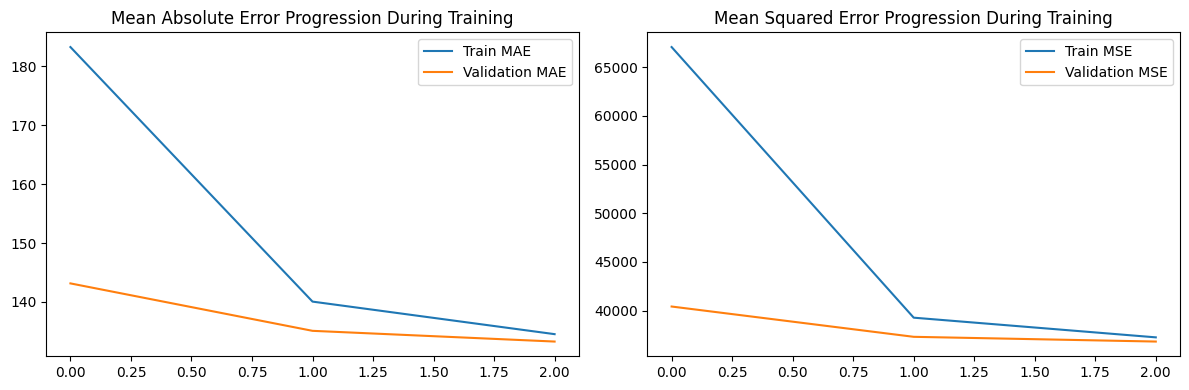

In [3]:
# Plot training history
import matplotlib.pyplot as plt

# Plot MAE and MSE
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title('Mean Absolute Error Progression During Training')

plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.title('Mean Squared Error Progression During Training')

plt.tight_layout()
plt.show()